# Social Media Data Analysis with Python-part2

This notebook trains a model to predict the **number of likes** a post will receive on a given day, based on historical data.

### **Steps:**

1. **Data Preparation:**
   - **Filter Users**: Only users with at least n posts are considered.
   - **Create Sequences**: For each user, we create sequences of `n` previous days' likes to predict the next day's likes.
   - **Normalization**: Likes are scaled for each user using MinMaxScaler.
   - **Train/Test Split**: Data is split into 80% for training and 20% for testing.

2. **Model Building:**
   - **LSTM Model**: A Long Short-Term Memory (LSTM) network is used to learn temporal patterns from the past likes.
   - **Layers**: The model includes an LSTM layer for sequence processing and a Dense layer for predicting the next day's likes.

3. **Training & Evaluation:**
   - The model is trained with the Adam optimizer and Mean Squared Error loss.
   - Predictions are made on the test set, and results are compared to actual likes.

4. **User-Specific**: The model is trained separately for each user to learn their unique patterns of likes.

---

This summary highlights the key steps for preparing data and training a model to predict likes over time.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load_raw_data 
fb_posts = pd.read_csv('fb_posts.csv')

# Convert 'dt' to datetime
fb_posts['dt'] = pd.to_datetime(fb_posts['dt'])

# Group by 'u_id' and count the 'p_id' occurrences
u_id_counts = fb_posts.groupby('u_id')['p_id'].count()

# Sort the result by count in descending order
sorted_u_id_counts = u_id_counts.sort_values(ascending=False)

# Filter users with at least 100 posts
filtered_u_id_counts =  u_id_counts[u_id_counts >= 100]

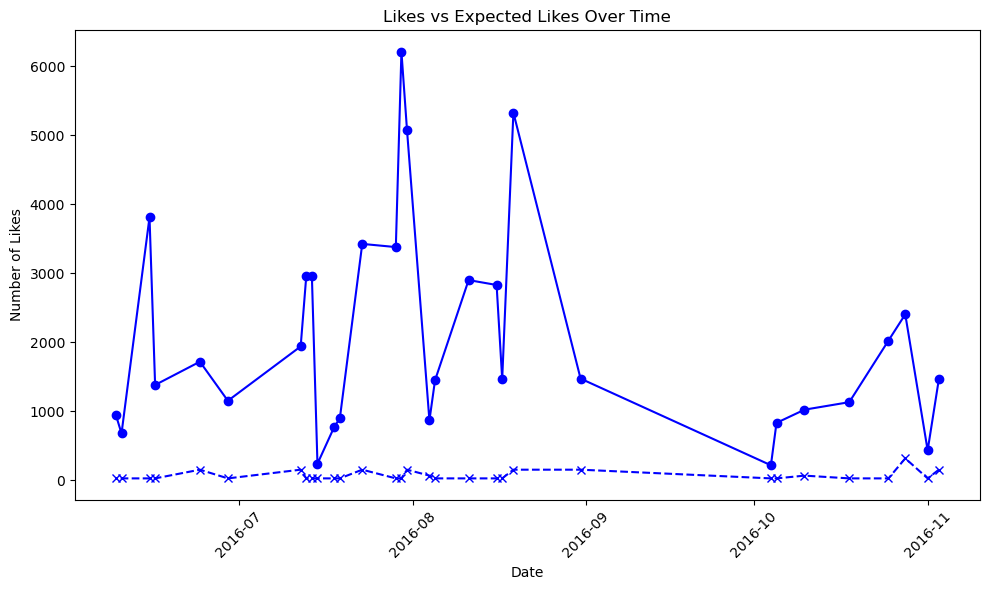

In [3]:
# Select the u_id values you want to plot
u_ids_to_plot = [sorted_u_id_counts.index[600]]

# Filter the DataFrame for the selected u_id values
df_filtered = fb_posts[fb_posts['u_id'].isin(u_ids_to_plot)]

# Plotting
plt.figure(figsize=(10, 6))

# Define colors for each u_id
colors = {u_ids_to_plot[0]: 'blue'}

# Loop through each u_id to plot likes and expected likes
for u_id in u_ids_to_plot:
    df_u_id = df_filtered[df_filtered['u_id'] == u_id]
    
    # Plot 'likes' with a solid line
    plt.plot(df_u_id['dt'], df_u_id['likes'], label=f'{u_id} Likes', color=colors[u_id], linestyle='-', marker='o')
    
    # Plot 'exp_likes' with a dashed line
    plt.plot(df_u_id['dt'], df_u_id['exp_likes'], label=f'{u_id} Exp Likes', color=colors[u_id], linestyle='--', marker='x')
    break
# Add labels and title
plt.title('Likes vs Expected Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Likes')

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Preparing the Data 

In [72]:
# Filtering users
df = fb_posts[fb_posts.u_id.isin(filtered_u_id_counts.index)]

# Create an empty list to store the sequences
X, y = [], []

# Sequence length (previous n days)
n = 99

scalers = []
# Iterate over each user and create sequences
for user in df['u_id'].unique():
    user_data = df[df['u_id'] == user].sort_values('dt')  # Sort by date for each user
    likes_data = user_data['likes'].values
    
    # Scale likes for each user separately
    scaler = MinMaxScaler(feature_range=(0, 1))
    likes_scaled = scaler.fit_transform(likes_data.reshape(-1, 1)).flatten()
    scalers.append(scaler)
    
    # Create sequences for the current user
    for i in range(len(likes_scaled) - n):
        X.append(likes_scaled[i:i + n])  # Last n days of likes
        y.append(likes_scaled[i + n])  # Predict the next day's like
    
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X for LSTM input [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(-1, 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Building the Model

In [73]:
# Build the LSTM model
model = Sequential()

# Add LSTM layers (you can adjust the number of units and layers)
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))

# Add a dense output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/data/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [95]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')


Epoch 1/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 125s 57ms/step - loss: 0.0074 - val_loss: 0.0147
Epoch 2/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 101s 46ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 3/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 139s 45ms/step - loss: 0.0075 - val_loss: 0.0146
Epoch 4/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 124s 56ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 5/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - loss: 0.0079 - val_loss: 0.0147
Epoch 6/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 154s 49ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 7/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 122s 55ms/step - loss: 0.0076 - val_loss: 0.0146
Epoch 8/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 102s 46ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 9/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 112s 51ms/step - loss: 0.0080 - val_loss: 0.0146
Epoch 10/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 111s 50ms/step - loss: 0.0077 - val_loss: 0.0146
553/553 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0134
Test loss: 0.014642988331615925


# Predictions

In [97]:
# Predict the likes for the next day
predicted_likes = model.predict(X_test)

553/553 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


In [98]:
# Inverse transform the predicted and actual values to get back to the original scale
predicted_likes_original = [j.inverse_transform([i]) for i,j in zip(predicted_likes,scalers)]
y_test_original = [j.inverse_transform([i]) for i,j in zip(y_test,scalers)] 

/tmp/ipykernel_2210619/1071203472.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_val, max_val], [min_val, max_val], 'k--', color='red', label="Perfect Prediction")


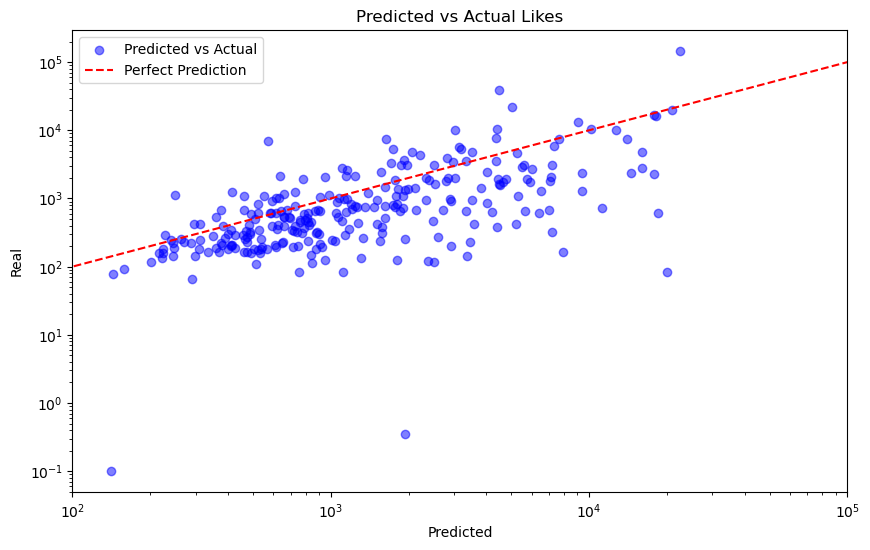

In [99]:
# Extracting values for scatter plot
predicted_values = [i[0][0] for i in predicted_likes_original]
real_values = [i[0][0] for i in y_test_original]

# Plot predicted likes vs actual likes
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, real_values, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Predicted vs Actual Likes')

# Add the diagonal line
min_val = min(min(predicted_values), min(real_values))
max_val = max(max(predicted_values), max(real_values))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', color='red', label="Perfect Prediction")

# Set log scale
plt.yscale('log')
plt.xscale('log')

plt.xlim([100,10**5])
plt.legend()
plt.show()


# Model Evaluation

In regression tasks, the error between the predicted and actual values is commonly measured using error metrics like **Mean Absolute Error (MAE)**, **Mean Squared Error (MSE)**, or **Root Mean Squared Error (RMSE)**. Since you’re comparing predicted likes vs. actual likes, these metrics are more informative than accuracy, which is typically used for classification.

Here's how you can calculate these error metrics:

### 1. Mean Absolute Error (MAE)
MAE calculates the average absolute difference between predicted and actual values.

\[
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} | \text{predicted}_i - \text{actual}_i |
\]

### 2. Mean Squared Error (MSE)
MSE calculates the average of squared differences, giving more weight to larger errors.

\[
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\text{predicted}_i - \text{actual}_i)^2
\]

### 3. Root Mean Squared Error (RMSE)
RMSE is the square root of MSE, keeping the metric in the same unit as the original values (likes in this case).

\[
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (\text{predicted}_i - \text{actual}_i)^2}
\]

### 4. Mean Absolute Percentage Error (MAPE)
If you’re interested in the relative error, MAPE gives the average percentage difference between predicted and actual values:

\[
\text{MAPE} = \frac{100\%}{N} \sum_{i=1}^{N} \left| \frac{\text{actual}_i - \text{predicted}_i}{\text{actual}_i} \right|
\]

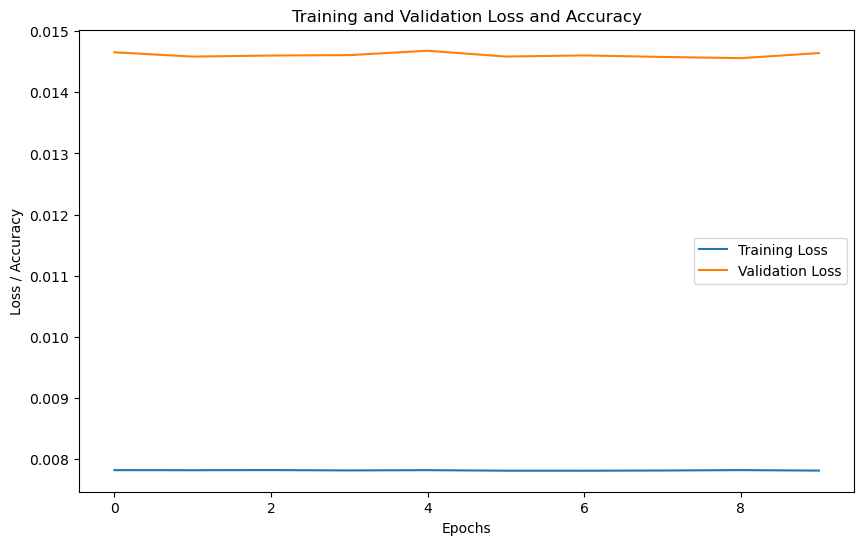

In [104]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))

# Plot training loss/metric
plt.plot(history.history['loss'], '-',label='Training Loss')
plt.plot(history.history['val_loss'], '-',label='Validation Loss')

# Plot accuracy if available
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.legend()
plt.show()

In [102]:
# Extract predicted and actual values
predicted_values = [i[0][0] for i in predicted_likes_original]
actual_values = [i[0][0] for i in y_test_original]

# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)  # squared=False for RMSE

# Calculate MAPE manually
mape = np.mean(np.abs((np.array(actual_values) - np.array(predicted_values)) / np.array(actual_values))) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 2183.9758691439097
Mean Squared Error (MSE): 71016101.5832457
Root Mean Squared Error (RMSE): 8427.105172195592
Mean Absolute Percentage Error (MAPE): 2894.186188428303%


/data/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
